In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/My Drive/Colab-Notebooks/Areal

/content/gdrive/My Drive/Colab-Notebooks/Areal


In [3]:
!pip install torch
!pip install torchvision
!pip install tqdm

  Using cached https://files.pythonhosted.org/packages/85/5e/e91792f198bbc5a0d7d3055ad552bc4062942d27eaf75c3e2783cf64eae5/Pillow-5.4.1-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [4]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
from PIL import Image

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import time
import os
import argparse
import torchvision
from torch.autograd import Variable 
from torchvision import transforms
from tqdm import tqdm

In [0]:
# problem_dir = 'ingestion_program/'  
# from sys import path; path.append(problem_dir)
# data_dir = '128x128_autoML'
# data_name = 'Areal'
# from ingestion_program.data_io import read_as_df
# data = read_as_df(data_dir  + '/' + data_name)

In [0]:
# from data_manager import DataManager
# D = DataManager(data_name, data_dir, replace_missing=False, verbose=True)
# print(D)

In [0]:
# import os
# path_train = 'RES13/train/'
# path_val = 'RES13/val/'
# os.makedirs(path_train)
# os.makedirs(path_val)
# for x in range(13):
#     if not os.path.exists(path_train+str(x)):
#         os.makedirs(path_train+'class_'+str(x))
#     if not os.path.exists(path_val+str(x)):
#         os.makedirs(path_val+'class_'+str(x))

In [0]:
# import scipy.misc
# import cv2

In [0]:
# X_train = D.data['X_train']
# Y_train = D.data['Y_train']
# for i in range(Y_train.shape[0]):
#     img = cv2.resize(X_train[i].reshape([128,128,3]), (256,256))
#     if img.shape[2]==3:
#         scipy.misc.imsave(path_train+'class_'+str(Y_train[i][0])+'/class_'+str(Y_train[i][0])+'_'+str(i)+'.jpg', img)
#     else:
#         print (i)

In [0]:
# X_valid = D.data['X_valid']
# Y_valid = D.data['Y_valid']
# for j in range(Y_valid.shape[0]):
#     img = cv2.resize(X_valid[j].reshape([128,128,3]), (256,256))
#     scipy.misc.imsave(path_val+'class_'+str(Y_valid[j][0])+'/class_'+str(Y_valid[j][0])+'_'+str(j)+'.jpg', img)
# print(j)

In [0]:
## Load the model 
# inception = torchvision.models.inception_v3(pretrained='imagenet')

In [0]:
resnet = torchvision.models.resnet50(pretrained='imagenet')

In [0]:
model_conv = resnet
freeze_layers = 1
n_class = 13

In [0]:
## Lets freeze the first few layers. This is done in two stages 
# Stage-1 Freezing all the layers 
freeze_layers = 1
if freeze_layers:
    for i, param in model_conv.named_parameters():
        param.requires_grad = False

# Since imagenet as 1000 classes , We need to change our last layer according to the number of classes we have,
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, n_class)

# Stage-2 , Freeze all the layers till "Conv2d_4a_3*3"
ct = []
for name, child in model_conv.named_children():
    #if "Conv2d_4a_3x3" in ct:
        for params in child.parameters():
            params.requires_grad = True
#     ct.append(name)
    
# To view which layers are freeze and which layers are not freezed:
# for name, child in model_conv.named_childeren():
#     for name_2, params in child.named_parameters():
#         print(name_2, params.requires_grad)

In [0]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, use_gpu, num_epochs=25, mixup = False, alpha = 0.1):
    if use_gpu:
        model.cuda()
        criterion.cuda()
    
    print("MIXUP".format(mixup))
    since = time.time()
    
    # graphs
    loss_values_train = []
    loss_values_valid = []
    acc_values_train = []
    acc_values_valid = []

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            print(phase)
            for data in tqdm(dataloaders[phase]):
                # get the inputs
                inputs, labels = data
                
                #augementation using mixup
                if phase == 'train' and mixup:
                    inputs = mixup_batch(inputs, alpha)
                    
                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                if type(outputs) == tuple:
                    outputs, _ = outputs
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            if phase == 'train':
                loss_values_train.append(epoch_loss)
                acc_values_train.append(epoch_acc)
            else:
                loss_values_valid.append(epoch_loss)
                acc_values_valid.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, ((loss_values_train, acc_values_train), (loss_values_valid, acc_values_valid))

In [17]:
## Loading the dataloaders -- Make sure that the data is saved in following way
"""
data/
  - train/
      - class_1 folder/
          - img1.png
          - img2.png
      - class_2 folder/
      .....
      - class_n folder/
  - val/
      - class_1 folder/
      - class_2 folder/
      ......
      - class_n folder/
"""

data_dir = "RES13"
input_shape = 224
batch_size = 64
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
scale = 360
input_shape = 224
use_parallel = False
use_gpu = True
epochs = 8

data_transforms = transforms.Compose([
        transforms.Resize(scale),
        transforms.RandomResizedCrop(input_shape),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=90),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])


image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                      data_transforms) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                         shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print (class_names)
print (dataset_sizes)

if use_parallel:
    print("[Using all the available GPUs]")
    model_conv = nn.DataParallel(model_conv, device_ids=[0, 1])

print("[Using CrossEntropyLoss...]")
criterion = nn.CrossEntropyLoss()

print("[Using small learning rate with momentum...]")
optimizer_conv = optim.SGD(list(filter(lambda p: p.requires_grad, model_conv.parameters())), lr=0.001, momentum=0.9)

print("[Creating Learning rate scheduler...]")
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

['class_0', 'class_1', 'class_10', 'class_11', 'class_12', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']
{'train': 5200, 'val': 1950}
[Using CrossEntropyLoss...]
[Using small learning rate with momentum...]
[Creating Learning rate scheduler...]


In [18]:
print("[Training the model begun ....]")
# train_model function
model_ft, t = train_model(model_conv, dataloaders, dataset_sizes, criterion, optimizer_conv, exp_lr_scheduler, use_gpu,
                     num_epochs=epochs)

[Training the model begun ....]


  0%|          | 0/82 [00:00<?, ?it/s]

MIXUP
Epoch 0/7
----------
train


  0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.0266 Acc: 0.5273
val


  0%|          | 0/82 [00:00<?, ?it/s]

val Loss: 0.0144 Acc: 0.7287

Epoch 1/7
----------
train


  0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.0112 Acc: 0.7831
val


  0%|          | 0/82 [00:00<?, ?it/s]

val Loss: 0.0087 Acc: 0.8241

Epoch 2/7
----------
train


  0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.0081 Acc: 0.8356
val


  0%|          | 0/82 [00:00<?, ?it/s]

val Loss: 0.0071 Acc: 0.8590

Epoch 3/7
----------
train


  0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.0070 Acc: 0.8579
val


  0%|          | 0/82 [00:00<?, ?it/s]

val Loss: 0.0059 Acc: 0.8774

Epoch 4/7
----------
train


  0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.0062 Acc: 0.8717
val


  0%|          | 0/82 [00:00<?, ?it/s]

val Loss: 0.0059 Acc: 0.8841

Epoch 5/7
----------
train


  0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.0055 Acc: 0.8871
val


  0%|          | 0/82 [00:00<?, ?it/s]

val Loss: 0.0054 Acc: 0.8944

Epoch 6/7
----------
train


  0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.0050 Acc: 0.8983
val


  0%|          | 0/82 [00:00<?, ?it/s]

val Loss: 0.0052 Acc: 0.8974

Epoch 7/7
----------
train


  0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.0046 Acc: 0.9083
val


100%|██████████| 31/31 [00:19<00:00,  2.35it/s]

val Loss: 0.0045 Acc: 0.9097

Training complete in 19m 15s
Best val Acc: 0.909744


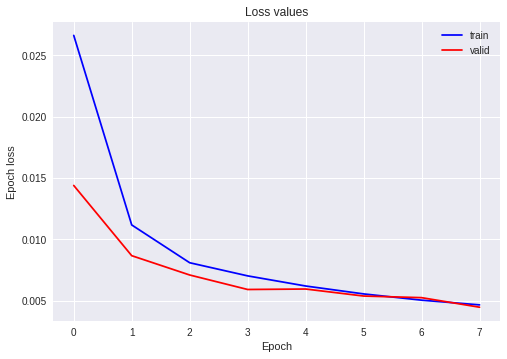

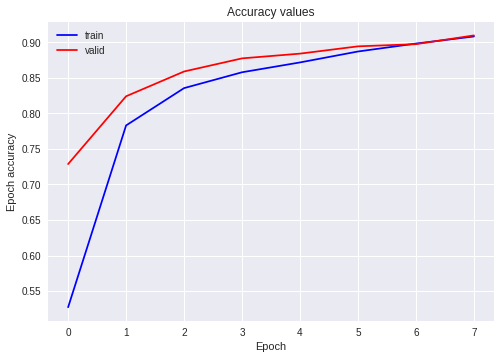

In [20]:
import matplotlib.pyplot as plt
#Loss
x = range(8)
plt.figure()
plt.plot(x, t[0][0], "b", label="train")
plt.plot(x, t[1][0], "r", label="valid")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Epoch loss")
plt.legend()
plt.savefig("Loss.png")
plt.show()
#Accu
x = range(8)
plt.figure()
plt.plot(x, t[0][1], "b", label="train")
plt.plot(x, t[1][1], "r", label="valid")
plt.title("Accuracy values")
plt.xlabel("Epoch")
plt.ylabel("Epoch accuracy")
plt.legend()
plt.savefig("Accu.png")
plt.show()

In [0]:
# tensor_data = torch.from_numpy(np.asarray(X_t).reshape([5200,1 ,3 , 256, 256]))
# tensor_data = tensor_data.float()
# tensor_target = torch.from_numpy(Y_train)
# train = torch.utils.data.TensorDataset(tensor_data, tensor_target)

# tensor_data = torch.from_numpy(np.asarray(X_v).reshape([1950,1, 3 , 256, 256]))
# tensor_data = tensor_data.float()
# tensor_target = torch.from_numpy(Y_valid)
# valid = torch.utils.data.TensorDataset(tensor_data, tensor_target)

# dataloaders = {'train': torch.utils.data.DataLoader(train, batch_size=batch_size,
#                                          shuffle=True, num_workers=4),
#                'valid': torch.utils.data.DataLoader(valid, batch_size=batch_size,
#                                          shuffle=True, num_workers=4)}

# dataset_sizes = {'train':5200,'val':1950}
# dataloaders = {'train':train,'val':valid}
# if use_parallel:
#     print("[Using all the available GPUs]")
#     model_conv = nn.DataParallel(model_conv, device_ids=[0, 1])d

In [21]:
print("[Training the model begun ....]")
# train_model function is here: https://github.com/Prakashvanapalli/pytorch_classifiers/blob/master/tars/tars_training.py
model_ft, t1 = train_model(model_conv, dataloaders, dataset_sizes, criterion, optimizer_conv, exp_lr_scheduler, use_gpu,
                     num_epochs=4)

  0%|          | 0/82 [00:00<?, ?it/s]

[Training the model begun ....]
MIXUP
Epoch 0/3
----------
train


  0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.0045 Acc: 0.9069
val


  0%|          | 0/82 [00:00<?, ?it/s]

val Loss: 0.0048 Acc: 0.9026

Epoch 1/3
----------
train


  0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.0045 Acc: 0.9025
val


  0%|          | 0/82 [00:00<?, ?it/s]

val Loss: 0.0044 Acc: 0.9082

Epoch 2/3
----------
train


  0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.0045 Acc: 0.9044
val


  0%|          | 0/82 [00:00<?, ?it/s]

val Loss: 0.0043 Acc: 0.9097

Epoch 3/3
----------
train


  0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.0045 Acc: 0.9065
val


100%|██████████| 31/31 [00:19<00:00,  2.32it/s]

val Loss: 0.0042 Acc: 0.9200

Training complete in 9m 38s
Best val Acc: 0.920000


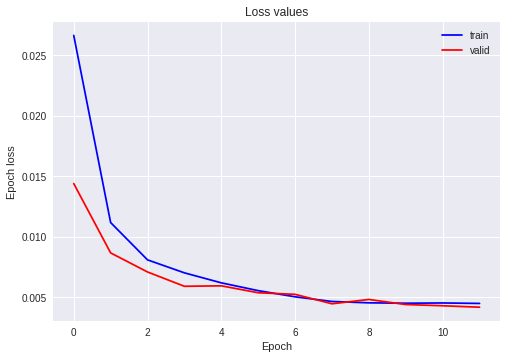

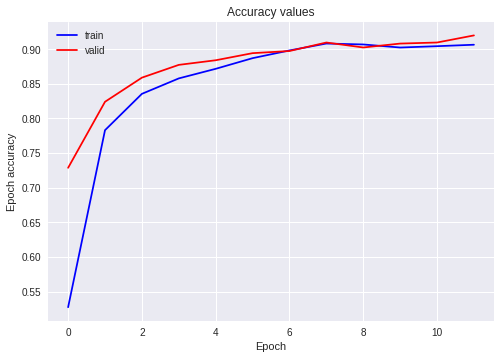

In [24]:
x = range(12)
plt.figure()
plt.plot(x, t[0][0]+t1[0][0], "b", label="train")
plt.plot(x, t[1][0]+t1[1][0], "r", label="valid")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Epoch loss")
plt.legend()
plt.savefig('Loss.png')
plt.show()

x = range(12)
plt.figure()
plt.plot(x, t[0][1]+t1[0][1], "b", label="train")
plt.plot(x, t[1][1]+t1[1][1], "r", label="valid")
plt.title("Accuracy values")
plt.xlabel("Epoch")
plt.ylabel("Epoch accuracy")
plt.legend()
plt.savefig('Acc.png')
plt.show()